### Importing

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import arch
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

### Download SPY data

In [2]:
spy = yf.download('SPY', start='2020-01-01', end=datetime.now().strftime('%Y-%m-%d'))
returns = 100 * spy['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


### Fit GARCH(1,1) model

In [3]:
model = arch.arch_model(returns, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
results = model.fit(disp='off')

### Generate 5-day ahead forecasts

In [4]:
forecasts = results.forecast(horizon=5)
conditional_vol = np.sqrt(forecasts.variance.values[-1, :])

### Get in-sample volatility

In [5]:
conditional_vol_in_sample = np.sqrt(results.conditional_volatility)

### Calculate realized volatility (21-day rolling standard deviation)

In [6]:
realized_vol = returns.rolling(window=21).std()

### Set regime thresholds based on historical percentiles

In [7]:

vol_25th = np.percentile(conditional_vol_in_sample, 25)
vol_75th = np.percentile(conditional_vol_in_sample, 75)
vol_90th = np.percentile(conditional_vol_in_sample, 90)

### Classify regimes

In [8]:
regimes = pd.Series(index=returns.index, data='Normal Vol')
regimes[conditional_vol_in_sample < vol_25th] = 'Low Vol'
regimes[conditional_vol_in_sample > vol_75th] = 'High Vol'
regimes[conditional_vol_in_sample > vol_90th] = 'Crisis'

### Create visualization

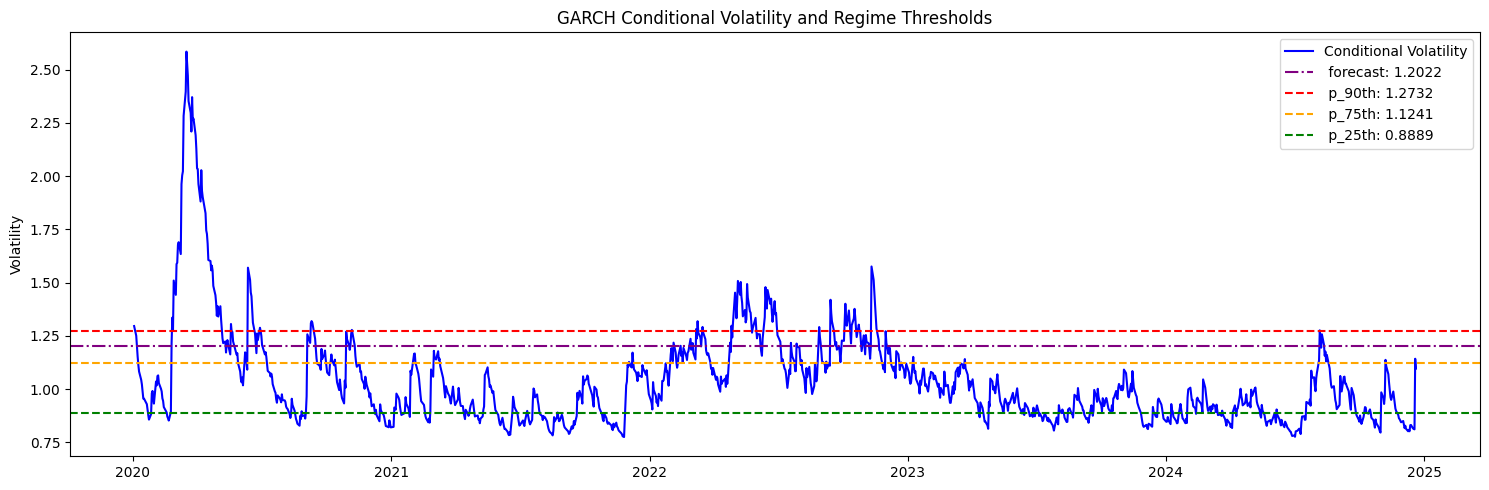

In [9]:
plt.figure(figsize=(15, 5))

plt.plot(returns.index, conditional_vol_in_sample, label='Conditional Volatility', color='blue')
plt.axhline(y=conditional_vol[0], color='purple', linestyle='-.', label=f' forecast: {conditional_vol[0]:.4f}')
plt.axhline(y=vol_90th, color='red', linestyle='--', label=f' p_90th: {vol_90th:.4f}')
plt.axhline(y=vol_75th, color='orange', linestyle='--', label=f' p_75th: {vol_75th:.4f}')
plt.axhline(y=vol_25th, color='green', linestyle='--', label=f' p_25th: {vol_25th:.4f}')
plt.title('GARCH Conditional Volatility and Regime Thresholds')
plt.legend()
plt.ylabel('Volatility')

plt.tight_layout()
plt.show()

### Print summary statistics

In [10]:
print("\nRegime Summary:")
print(regimes.value_counts())


Regime Summary:
Normal Vol    625
Low Vol       313
High Vol      188
Crisis        125
Name: count, dtype: int64
